In [14]:
# imports
import numpy as np
import pandas as pd
import glob
import mediapipe as mp # for hand detection
import cv2 # for capturing videos
import pickle # to save the model
import argparse
import os
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as pl
from PIL import Image
from tqdm import tqdm

In [15]:
# initialize mediapipe
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

In [16]:
# CONSTANTS
# Path to the data folder : 300x300 images, padding, no cropping
frames_300x300_AfP = glob.glob("../data/different_input_size_60fps/300_300_AfP/*.png")

# Path to the data folder : 300x300 images, no padding, cropping
frames_300x300_AfC = glob.glob("../data/different_input_size_60fps/300_300_AfC/*.png")

In [17]:
# load all video frames into numpy array
all_frames = np.array([np.array(Image.open(fname)) for fname in tqdm (frames_300x300_AfC)])
print(all_frames.shape)
print(type(all_frames))

100%|██████████| 28854/28854 [03:36<00:00, 133.32it/s]


(28854, 300, 300, 3)
<class 'numpy.ndarray'>


In [18]:
# drop last 28 frames from all_frames to match ground_truth shape
all_frames = all_frames[:-28]
print(all_frames.shape)

(28826, 300, 300, 3)


In [20]:
# select just 100 of the 28'826 frames to test the algorithm
test_frames = all_frames[0:200]
print(test_frames.shape)

(200, 300, 300, 3)


In [21]:
# initialize variables
# hands is a list of lists, each list contains the coordinates of the center of the hand in each frame and the frame index
# initialize variables
hands = []

with mp_hands.Hands(static_image_mode=True,
                    max_num_hands=2,
                    min_detection_confidence=0.5) as hand:

    for frame_index in tqdm(range(all_frames.shape[0])):
        image = all_frames[frame_index,:,:,:]
        image_width = image.shape[1]
        image_height = image.shape[0]

        results_hand = hand.process(image)

        # create variables to store the landmarks of both hands
        first_hand_landmarks = None
        second_hand_landmarks = None

        if results_hand.multi_hand_landmarks:
            landmarks1 = results_hand.multi_hand_landmarks[0] # first hand detected
            first_hand_landmarks = []
            for landmark in landmarks1.landmark:
                first_hand_landmarks.append([landmark.x, landmark.y, landmark.z])

            if len(results_hand.multi_hand_landmarks) > 1:
                landmarks2 = results_hand.multi_hand_landmarks[1] # second hand detected
                second_hand_landmarks = []
                for landmark in landmarks2.landmark:
                    second_hand_landmarks.append([landmark.x, landmark.y, landmark.z])

        hands.append([frame_index, first_hand_landmarks, second_hand_landmarks])

100%|██████████| 28826/28826 [43:18<00:00, 11.09it/s] 


In [22]:
# save the hands coordinates to a pickle file in the pickle_files folder
file_name = os.path.join(".", "pickle_data", "300_300_AfC_hands_coordinates_21_landmarks.pickle")
with open(file_name, "wb") as f:
    pickle.dump(hands, f)

In [23]:
# load the hands coordinates from the pickle file
file_name = os.path.join(".", "pickle_data", "300_300_AfC_hands_coordinates_21_landmarks.pickle")
with open(file_name, "rb") as f:
    hands = pickle.load(f)

# display the hands coordinates
hands


[[0,
  [[0.6789267659187317, 0.7166826725006104, 2.0850416149187367e-07],
   [0.6730109453201294, 0.6843450665473938, 0.004473347682505846],
   [0.6550570726394653, 0.6505052447319031, 0.006036499049514532],
   [0.6391341090202332, 0.629127562046051, 0.005319010931998491],
   [0.6273966431617737, 0.6115303635597229, 0.0038206814788281918],
   [0.651879608631134, 0.6486257910728455, 0.002629668451845646],
   [0.6330584287643433, 0.6128019094467163, -0.0069520906545221806],
   [0.6197682023048401, 0.5841107964515686, -0.014755076728761196],
   [0.6083027124404907, 0.5616125464439392, -0.01992180198431015],
   [0.6471923589706421, 0.648056149482727, -0.005564892198890448],
   [0.6261138916015625, 0.6058703660964966, -0.014680745080113411],
   [0.6102589964866638, 0.5742369294166565, -0.02269960567355156],
   [0.5950872302055359, 0.546645998954773, -0.028351115062832832],
   [0.640681266784668, 0.6509824395179749, -0.014078854583203793],
   [0.6218274235725403, 0.6098476052284241, -0.02173

In [24]:
hands[3]

[3, None, None]

In [25]:
frames_with_hands = 0
frames_with_both_hands = 0

for hand in hands:
    if hand[1] != None or hand[2] != None:
        frames_with_hands += 1
    if hand[1] != None and hand[2] != None:
        frames_with_both_hands += 1

print("Percentage of frames with at least one hand detected : ", frames_with_hands/len(hands)*100, "%")
print("Percentage of frames with both hands detected : ", frames_with_both_hands/len(hands)*100, "%")

Percentage of frames with at least one hand detected :  70.64108790675085 %
Percentage of frames with both hands detected :  21.834455005897453 %


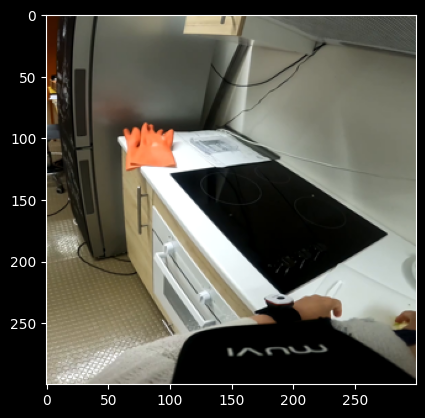

In [26]:
# show one random frame of the train_set with the detected hand

import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# select a random frame
frame_index = random.randint(0, test_frames.shape[0]-1)
image = test_frames[frame_index,:,:,:]
image_width = image.shape[1]
image_height = image.shape[0]

# display the frame
fig, ax = plt.subplots(1)
ax.imshow(image)

# display first hand in the frame if detected
if hands[frame_index][1] is not None:
    rect = patches.Rectangle((hands[frame_index][1][0]-30, hands[frame_index][1][1]-30), 50, 50, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# display center of the first hand in the frame if detected
if hands[frame_index][1] is not None:
    rect = patches.Rectangle((hands[frame_index][1][0]-5, hands[frame_index][1][1]-5), 10, 10, linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

# display second hand in the frame if detected
if hands[frame_index][2] is not None:
    rect = patches.Rectangle((hands[frame_index][2][0]-30, hands[frame_index][2][1]-30), 50, 50, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# display center of the second hand in the frame if detected
if hands[frame_index][2] is not None:
    rect = patches.Rectangle((hands[frame_index][2][0]-5, hands[frame_index][2][1]-5), 10, 10, linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

plt.show()